In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [2]:
DATA_PATH = "./data/data-003/"

In [3]:
def load_data(train_path, test_path):
    return pd.read_csv(train_path), pd.read_csv(test_path)

def getIndexByType(df):
    num_attribs = df.dtypes[df.dtypes != "object"].index
    cat_attribs = df.dtypes[df.dtypes == "object"].index
    return num_attribs, cat_attribs

def getNaNinfo(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    kesson_table = pd.concat([null_val, percent], axis=1)
    kesson_table_ren_columns = kesson_table.rename(
        columns = {0:'欠損数', 1:'%'}
    )
    return kesson_table_ren_columns

def delNaNaxis(df, minPer=100.0):
    info_nan = getNaNinfo(df)
    index = info_nan[info_nan["%"] <= minPer].index
    return df[index], index

def saveData(nData, nID, colName, fileName):
    pdData = pd.DataFrame(nData, nID, columns = [colName])
    pdData.to_csv(DATA_PATH + fileName + ".csv", index_label=["Id"])
    print(DATA_PATH + fileName + ".csv")

In [4]:
import tensorflow as tf
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin) :
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion

def conv_data(data, num_attribs, cat_attribs):
    num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
    
    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False),)
    ])
    
    full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
    
    data[cat_attribs] = data[cat_attribs].fillna("-")
    
    output = full_pipeline.fit_transform(data)
    return output

In [7]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china,flower],dtype=np.float32)

In [8]:
batch_size, height, width, channels = dataset.shape

In [9]:
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

In [10]:
reset_graph()
X = tf.placeholder(tf.float32,shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=(1,2,2,1), strides=[1,2,2,1], padding="VALID")
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1],padding="SAME")

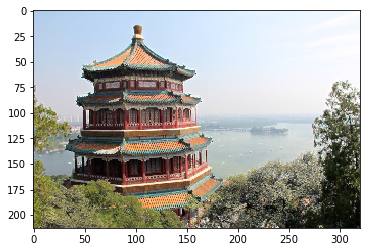

In [11]:
with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X:dataset})

# plt.imshow(output[0,:,:,1], cmap="gray")
plt.imshow(output[0].astype(np.uint8))
plt.show()

In [12]:
output.shape

(2, 213, 320, 3)

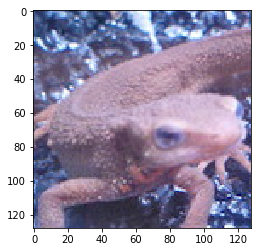

In [13]:
import matplotlib.image as mpimg
# img =  mpimg.imread(os.path.join(DATA_PATH,"test.jpeg"))[:, :, :channels]
img =  mpimg.imread(os.path.join(DATA_PATH,"imori.jpg"))[:, :, :channels]
plt.imshow(img)
plt.show()

In [14]:
class ImageProc:
    def __init__(self, img):
        self.img = img
    def __setParam(self, img):
        self.img = img
    def grayscale(self):
        """
        グレースケール
        """
        img = self.img.copy()
        img_gray = img[:,:,0] * 0.2126 + img[:,:,1] * 0.7152 + img[:,:,2] * 0.0722
        pil_img_gray = Image.fromarray(np.uint8(img_gray))
        return pil_img_gray
    def __binary(self,img,thre):
        img_bin = np.where(img < thre,0,255)
        img_bin = Image.fromarray(np.uint8(img_bin))
        return img_bin
    def binary(self,thre=None):
        """
        二値化
        Parameters
        ----------
        thre : int
            閾値。未指定の場合は自動式別(大津の判別分析法)
        """
        img = np.asarray(self.grayscale())
        if(thre != None):
            return self.__binary(img, thre)
        else:
            max_s = (0, -10)
            for t in range(256):
                img_h1, img_h2 = img[img <= t], img[img > t]
                c1, c2 = img_h1.size,img_h2.size
                m1,m2 = img_h1.mean(),img_h2.mean()
                s = c1 * c2 * (m1 - m2) ** 2
                if s > max_s[1]:
                    max_s = (t,s)
            print(max_s[0])
            return self.__binary(img,max_s[0])
    def HSV(self, hue=180):
        """
        HSV空間変換
        """
        r = self.img[:,:,0].copy()
        g = self.img[:,:,1].copy()
        b = self.img[:,:,2].copy()
        out = np.zeros_like(self.img)
        
        max_v = np.max(self.img, axis=2).copy()
        min_v = np.min(self.img, axis=2).copy()
        min_arg = np.argmin(self.img,axis=2)
        
        H = np.zeros_like(max_v)
        
        for num, i in enumerate(range(0,1,2)):
            ind = np.where(min_arg == i)
            _ind = np.where((max_v[ind] - min_v[ind]) == 0)
            H[ind][_ind] = 0
            _ind = np.where((max_v[ind] - min_v[ind]) > 0)
            H[ind][_ind] = 60. * (self.img[..., ((i+1)%3)][ind][_ind] - self.img[..., ((i+2)%3)][ind][_ind]) / (max_v[ind] - min_v[ind])[_ind] + 60. * (2*num+1)
            
        V = max_v.copy()
        S = max_v.copy() - min_v.copy()
        
        H += hue % 360
        
        C = S
        H_ = H / 60
        X = C * (1 - np.abs( H_ % 2 - 1))
        Z = np.zeros_like(H)

        vals = [[Z,X,C], [Z,C,X], [X,C,Z], [C,X,Z], [C,Z,X], [X,Z,C]]

        for i in range(6):
            ind = np.where((i <= H_) & (H_ < (i+1)))
            out[..., 0][ind] = (V-C)[ind] + vals[i][0][ind]
            out[..., 1][ind] = (V-C)[ind] + vals[i][1][ind]
            out[..., 2][ind] = (V-C)[ind] + vals[i][2][ind]

        out[np.where(max_v == min_v)] = 0
        out = (out * 255).astype(np.uint8) 
        
        return out
    def colorReduction(self):
        """
        減色処理
        """
        out = self.img.copy()
        num = 16
        val = 256//num
        for i in range(num):
            ind = np.where(((val*i  -1) < self.img) & ((val*(i+1)) >= self.img))
            out[ind] = val * (i+1) 
        return out
    def pooling(self,g,proc="average"):
        out = self.img.copy()
        H,W,C = out.shape
        nw = W//g
        nh = H // g
        for w in range(nw):
            for h in range(nh):
                for c in range(C):
                    if proc == "average":
                        out[h*g:(h+1)*g, w*g:(w+1)*g,c] = self.img[h*g:(h+1)*g, w*g:(w+1)*g,c].mean()
                    elif proc == "max":
                        out[h*g:(h+1)*g, w*g:(w+1)*g,c] = self.img[h*g:(h+1)*g, w*g:(w+1)*g,c].max()
        return out
    def gausian(self,k_size):
        #param
        sigma = 1.3
        
        # Padding
        H,W,C = self.img.shape
        pad = k_size // 2
        out = np.zeros((H+pad*2,W+pad*2,C), dtype=np.float)
        out[pad:pad+H, pad:pad+W] = self.img.copy().astype(np.float)
        
        # kernel
        k = np.zeros((k_size,k_size),dtype=np.float)
        for x in range(-pad, -pad+k_size):
            for y in range(-pad, -pad+k_size):
                k[y+pad, x+pad] = np.exp(-(x**2 + y**2) / (2 * (sigma**2)))
        k /= np.sqrt(2 * np.pi) * sigma
        k /= k.sum()
        
        # proc
        for y in range(H):
            for x in range(W):
                for c in range(C):
                    out[y+pad, x+pad, c] = np.sum(k * out[y:y+k_size, x:x+k_size, c])
        out = out[pad:pad+H, pad:pad+W].astype(np.uint8)
        return out
    def median(self, k_size):
        # padding
        H,W,C = self.img.shape
        pad = k_size // 2
        out = np.zeros((H+pad*2, W+pad*2, C),dtype=np.float)
        out[pad:pad+H, pad:pad+W] = self.img.copy().astype(np.float)
        
        #proc
        for x in range(H):
            for y in range(W):
                for c in range(C):
                    out[y+pad,x+pad,c] = np.median(out[y:y+k_size, x:x+k_size, c])
        out = out[pad:pad+H, pad:pad+W].astype(np.uint8)
        return out
    def smoothing(self, k_size):
        # padding
        H,W,C = self.img.shape
        pad = k_size // 2
        out = np.zeros((H+pad*2, W+pad*2, C),dtype=np.float)
        out[pad:pad+H, pad:pad+W] = self.img.copy().astype(np.float)
        
        #proc
        for x in range(H):
            for y in range(W):
                for c in range(C):
                    out[y+pad,x+pad,c] = np.mean(out[y:y+k_size, x:x+k_size, c])
        out = out[pad:pad+H, pad:pad+W].astype(np.uint8)
        return out
    def motion(self, k_size, direction=0):
        # padding
        H,W,C = self.img.shape
        pad = k_size // 2
        out = np.zeros((H+pad*2, W+pad*2, C),dtype=np.float)
        out[pad:pad+H, pad:pad+W] = self.img.copy().astype(np.float)
        
        #kernel
        k = np.eye(k_size,dtype=np.float) / k_size
        
        #proc
        for x in range(H):
            for y in range(W):
                for c in range(C):
                    out[y+pad,x+pad,c] = np.sum(out[y:y+k_size, x:x+k_size,c] * k)
        out = out[pad:pad+H, pad:pad+W].astype(np.uint8)
        return out
    def maxmin(self,k_size):
        # pad
        gray = np.array(self.grayscale())
        H,W = gray.shape
        pad = k_size // 2
        
        out = np.zeros((H+pad*2, W+pad*2),dtype=np.float)
        out[pad:pad+H, pad:pad+W] = gray.copy()
        tmp = out.copy()
        
        # proc
        for x in range(W):
            for y in range(H):
                out[y+pad, x+pad] = tmp[y:y+k_size, x:x+k_size].max() - tmp[y:y+k_size, x:x+k_size].min()
        PIL_out  = Image.fromarray(np.uint8(out))
        return PIL_out
    def derivation(self, direction="H"):
        gray = np.array(self.grayscale())
        H, W = gray.shape
        k_size = 3
        pad = k_size // 2
        out = np.zeros((H+pad*2, W+pad*2),dtype=np.float)
        out[pad:pad+H, pad:pad+W] = gray.copy()
        tmp = out.copy()
        
        k = np.zeros((k_size,k_size),dtype=np.float)
        if direction in "H":
            k[1, 1] = 1
            k[0, 1] = -1
        elif direction in "W":
            k[1, 1] = 1
            k[1, 0] = -1
        
        for x in range(W):
            for y in range(H):
                out[y+pad, x+pad] = np.mean(tmp[y:y+k_size, x:x+k_size] * k)
        PIL_out = Image.fromarray(np.uint8(out))
        return PIL_out
    def filterling(self,k,proc="sum"):
        gray = np.array(self.grayscale())
        H,W = gray.shape
        k_size = k.shape[0]
        pad = k_size // 2
        out = np.zeros((H+pad*2, W+pad*2),dtype=np.float)
        out[pad:pad+H, pad:pad+W] = gray.copy()
        tmp = out.copy()
        if proc in "sum":
            for x in range(W):
                for y in range(H):
                    out[pad+y, pad+x] = np.sum(tmp[y:y+k_size, x:x+k_size] * k)
        elif proc in "mean":
            for x in range(W):
                for y in range(H):
                    out[pad+y, pad+x] = np.mean(tmp[y:y+k_size, x:x+k_size] * k)
        PIL_out = Image.fromarray(np.uint8(out))
        return PIL_out    
    def sobel(self, direction="H"):
        k_size = 3
        k = np.zeros((k_size, k_size),dtype=np.float)
        k[:,0] = -1,-2,-1
        k[:,2] = k[:,0]*-1
        if direction in "H":
            k = k.T
        return self.filterling(k)
    def prewitt(self,direction="H"):
        k_size = 3
        k = np.zeros((k_size, k_size),dtype=np.float)
        k[:,0] = 1
        k[:,2] = k[:,0]*-1
        if direction in "H":
            k = k.T
        return self.filterling(k)
    def laplacian(self):
        k_size = 3
        k = np.ones((k_size, k_size),dtype=np.float)
        k[0::2,::2] = 0
        k[1,1] = -4
        print(k)
        return self.filterling(k)
    def emboss(self):
        k_size = 3
        k = np.array([[-2., -1., 0.], [-1., 1., 1.], [0., 1., 2.]])
        print(k)
        return self.filterling(k)
    def LoG(self):
        sigma = 3
        k_size = 5
        pad = k_size //2
        k = np.zeros((k_size, k_size),dtype=np.float)
        for x in range(-pad, -pad + k_size):
            for y in range(-pad, -pad + k_size):
                k[x+pad, y+pad] = (x**2 + y**2 - sigma**2) * (np.exp(-(x**2 + y**2)/(2*np.pi**2)))
        k /= (2*np.pi*sigma**6)
        k /= k.sum()
        print(k)
        sns.heatmap(k)
        return self.filterling(k)
    def histgram_normed(self, rmin=0, rmax=255):
        vmin  = self.img.min()
        vmax = self.img.max()
        out = self.img.copy()
        out[out<rmin] = rmin
        out[out>rmax] = rmax
        out = (rmax - rmin) / (vmax - vmin) * (out - vmin) + vmin
        out = out.astype(np.uint8)
        return out        
    def histgram_oper(self, m0=128, s0=52):
        out = self.img.copy()
        m = out.mean()
        s = out.std()
        out = s0 / s * (out - m) + m0
        return out        
    def histgram_flattening(self):
        out = self.img.copy()
        H,W,C = out.shape
        S = H * W * C * 1.
        Zmax = out.max()
        Hsum = 0.
        
        for i in range(1,255):
            ind = np.where(self.img == i)
            Hsum += len(self.img[ind])
            Zprime = Zmax / S * Hsum
            out[ind] = Zprime
        return out
    def gammaCorrection(self, c=1, gamma=2.2):
        out = self.img.copy().astype(np.float32)
        out /= 255.
        out = (1/c * out) ** (1/gamma)
        out *= 255.
        return out.astype(np.uint8)        
    def nearestNeighbor(self, expand=1.5):
        H,W,C = self.img.shape
        ay = int(expand * H)
        ax = int(expand * W)
        Y = np.arange(ay).repeat(ax).reshape(ax,-1)
        X = np.tile(np.arange(ax),(ay,1))
        Y = np.round(Y / expand).astype(np.int)
        X = np.round(X / expand).astype(np.int)
        out = self.img[Y,X].astype(np.uint8)
        return out
    def bilinear(self, expand=1.5):
        H,W,C = self.img.shape
        ay = int(expand * H)
        ax = int(expand * W)
        Y = np.arange(ay).repeat(ax).reshape(ax,-1)
        X = np.tile(np.arange(ax),(ay,1))
        Y = Y / expand
        X = X / expand
        
        ix = np.floor(X).astype(np.int)
        iy = np.floor(Y).astype(np.int)
        ix= np.minimum(ix, W-2)
        iy = np.minimum(iy, H-2)
        dx = ix - X
        dy = iy - Y
        dx = np.repeat(np.expand_dims(dx, axis=-1), 3, axis=-1)
        dy = np.repeat(np.expand_dims(dy, axis=-1), 3, axis=-1)
        
        tmp = self.img.copy()
        
        out = (1-dx) * (1-dy) * tmp[iy, ix] + dx * (1 - dy) * tmp[iy, ix+1] + (1 - dx) * dy * tmp[iy+1, ix] + dx * dy * tmp[iy+1, ix+1]

        out[out>255] = 255
        out = out.astype(np.uint8)
        
        return out
    def affin(self, sx=1., sy=1., tx=0., ty=0.):
        H,W,C = self.img.shape
        img = np.zeros((H+2,W+2,C),dtype=np.float32)
        img[1:H+1, 1:W+1] = self.img
        aH = np.round(H * sy).astype(np.int)
        aW = np.round(W * sx).astype(np.int)
        out = np.zeros((aH+1,aW+1,C),dtype=np.float32)

        ax = np.tile(np.arange(aW),(aH,1))
        ay = np.arange(aH).repeat(aW).reshape(aH,-1)
        z = sx*sy
        x = np.round((sy * ax) / z).astype(np.int) - tx + 1
        y = np.round((sx * ay) / z).astype(np.int) - ty + 1

        y = np.minimum(np.maximum(y,0),H+1).astype(np.int)
        x = np.minimum(np.maximum(x,0),W+1).astype(np.int)
        out[ay,ax] = img[y,x]
        out = out[:aH, :aW]
        return out.astype(np.uint8)
    def affinRotate(self, theta=0., tx=0., ty=0.):
        H,W,C = self.img.shape
        img = np.zeros((H+2,W+2,C),dtype=np.float32)
        img[1:H+1, 1:W+1] = self.img
        aH = np.round(H).astype(np.int)
        aW = np.round(W).astype(np.int)
        out = np.zeros((aH+1,aW+1,C),dtype=np.float32)
        theta = -np.pi * theta / 180.
        a = np.cos(theta)
        b = -np.sin(theta)
        c = np.sin(theta)
        d = np.cos(theta)
    
        ax = np.tile(np.arange(aW),(aH,1))
        ay = np.arange(aH).repeat(aW).reshape(aH,-1)
        z = a*d - b*c
        x = np.round((d * ax - b * ay) / z).astype(np.int) - tx + 1
        y = np.round((-c * ax + a * ay) / z).astype(np.int) - ty + 1

        y = np.minimum(np.maximum(y,0),H+1).astype(np.int)
        x = np.minimum(np.maximum(x,0),W+1).astype(np.int)
        out[ay,ax] = img[y,x]
        out = out[:aH, :aW]
        return out.astype(np.uint8)
    def affinSkew(self, theta=0., tx=0., ty=0.):
        H,W,C = self.img.shape
        img = np.zeros((H+2,W+2,C),dtype=np.float32)
        img[1:H+1, 1:W+1] = self.img
        aH = np.round(H).astype(np.int)
        aW = np.round(W).astype(np.int)
        out = np.zeros((aH+1,aW+1,C),dtype=np.float32)
        theta = -np.pi * theta / 180.
        a = 1
        b = 0
        c = np.tan(theta)
        d = 1
    
        ax = np.tile(np.arange(aW),(aH,1))
        ay = np.arange(aH).repeat(aW).reshape(aH,-1)
        z = a*d - b*c
        x = np.round((d * ax - b * ay) / z).astype(np.int) - tx + 1
        y = np.round((-c * ax + a * ay) / z).astype(np.int) - ty + 1

        y = np.minimum(np.maximum(y,0),H+1).astype(np.int)
        x = np.minimum(np.maximum(x,0),W+1).astype(np.int)
        out[ay,ax] = img[y,x]
        out = out[:aH, :aW]
        return out.astype(np.uint8)



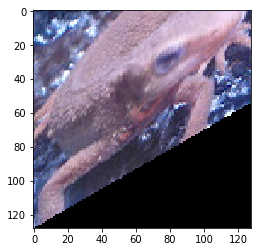

In [15]:
# fig = plt.figure(figsize=(9,6))
# ax1 = fig.add_subplot(1,4,1)
# ax2 = fig.add_subplot(1,4,2)
# ax3 = fig.add_subplot(1,4,3)
# ax4 = fig.add_subplot(1,4,4)

imgp = ImageProc(img)
plt.imshow(imgp.affinSkew(theta=30))

# ax1.imshow(imgp.gammaCorrection(gamma=0.2))
# ax2.imshow(imgp.gammaCorrection(gamma=1.2))
# ax3.imshow(imgp.gammaCorrection(gamma=2.2))
# ax4.imshow(imgp.gammaCorrection(gamma=3.2))

# plt.hist(imgp.histgram_flattening().ravel(), bins=255, rwidth=0.8, range=(0,255))
# plt.show()

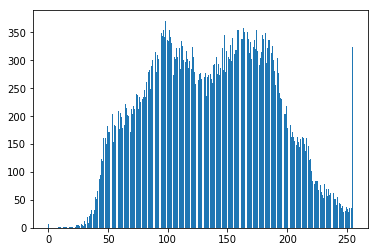

In [16]:
plt.hist(img.ravel(), bins=255, rwidth=0.8, range=(0,255))
plt.show()

In [17]:
# fig = plt.figure(figsize=(9,6))
# ax1 = fig.add_subplot(1,4,1)
# ax2 = fig.add_subplot(1,4,2)
# ax3 = fig.add_subplot(1,4,3)
# ax4 = fig.add_subplot(1,4,4)

# ax1.imshow(img_r)
# ax2.imshow(img_g)
# ax3.imshow(img_b)
# ax4.imshow(pil_img_bin)

# # plt.imshow(out)

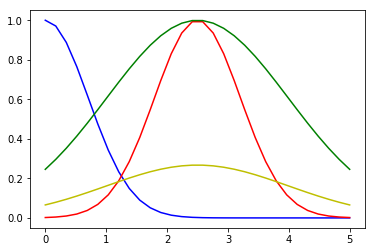

In [18]:
# x = np.arange(-50,100)
x = np.linspace(0,5,30)
y1 = np.exp(-x**2)
y2 = np.exp(-(x-x.mean())**2)
y3 = np.exp(-((x-x.mean())**2)/(2*x.var()))
y4 = y3 / (np.sqrt(2*np.pi*x.var()))
plt.plot(x,y1,'b')
plt.plot(x,y2,'r')
plt.plot(x,y3,'g')
plt.plot(x,y4,'y')

(40,)
[2.5767572e-18 2.2824560e-16 1.5542526e-14 8.1362532e-13 3.2742684e-11
 1.0129609e-09 2.4091136e-08 4.4046405e-07 6.1908490e-06 6.6892360e-05
 5.5563601e-04 3.5480591e-03 1.7417230e-02 6.5728538e-02 1.9068483e-01
 4.2527062e-01 7.2912461e-01 9.6100420e-01 9.7372419e-01 7.5846177e-01
 4.5417017e-01 2.0906943e-01 7.3986016e-02 2.0127783e-02 4.2094882e-03
 6.7678350e-04 8.3648469e-05 7.9478959e-06 5.8054212e-07 3.2598912e-08
 1.4072102e-09 4.6698471e-11 1.1913312e-12 2.3364113e-14 3.5225101e-16
 4.0826889e-18 3.6376896e-20 2.4916784e-22 1.3120245e-24 5.3110923e-27]


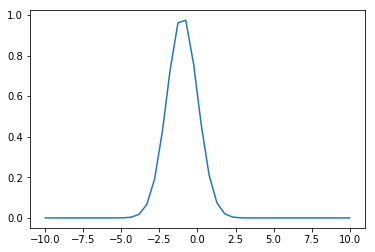

In [19]:
Z = np.linspace(-10,10,40).astype(np.float32)
def gauss(narray, gamma=0.5):
    px = -1.
    out =  np.exp(-gamma*(narray - px)**2)
    print(out.shape)
    print(out)
    return np.c_[narray,out]

Y = gauss(Z)
plt.plot(Y[:,0],Y[:,1])
    

In [20]:
s = 90.
ss = -np.pi * s / 180.
ss
# np.cos(s)
# Z = -np.pi * theta / 180.


-1.5707963267948966

In [21]:
# import mnist_reader
# DATA_FA = '/Users/hiramatsuyuuki/Work/50.python/80.data'
# X_train, y_train = mnist_reader.load_mnist(DATA_FA, kind='train')
# X_test, y_test = mnist_reader.load_mnist(DATA_FA, kind='t10k')

In [22]:
# a = X_train[0].reshape(28,28)
# a = Image.fromarray(np.uint8(a))
# plt.imshow(a)

In [23]:
# X_train_6, y_train_6 = X_train[y_train==6], y_train[y_train==6]

In [24]:
# #訓練画像
# train_no = 0
# outImg = Image.fromarray(X_train[train_no].reshape((28,28))*255).convert("RGB")
# outImg.save("train.png")

In [25]:
# from sklearn.linear_model import SGDClassifier
# sgd_clf = SGDClassifier()
# sgd_clf.fit(X_train, y_train)

In [26]:
# y_pred = sgd_clf.predict(X_test)

In [27]:
# from sklearn.metrics import accuracy_score
# accuracy_score(y_pred, y_test)

In [28]:
# from sklearn.metrics import confusion_matrix
# conf_matrix = confusion_matrix(y_pred, y_test)
# plt.matshow(conf_matrix, cmap=plt.cm.gray)

In [29]:
from PIL import Image
import sys

import pyocr
import pyocr.builders

tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("No OCR tool found")
    sys.exit(1)
# The tools are returned in the recommended order of usage
tool = tools[0]
print("Will use tool '%s'" % (tool.get_name()))
# Ex: Will use tool 'libtesseract'

langs = tool.get_available_languages()
print("Available languages: %s" % ", ".join(langs))
lang = langs[0]
print("Will use lang '%s'" % (lang))

Will use tool 'Tesseract (sh)'
Available languages: afr, amh, ara, asm, aze, aze_cyrl, bel, ben, bod, bos, bre, bul, cat, ceb, ces, chi_sim, chi_sim_vert, chi_tra, chi_tra_vert, chr, cos, cym, dan, deu, div, dzo, ell, eng, enm, epo, est, eus, fao, fas, fil, fin, fra, frk, frm, fry, gla, gle, glg, grc, guj, hat, heb, hin, hrv, hun, hye, iku, ind, isl, ita, ita_old, jav, jpn, jpn_vert, kan, kat, kat_old, kaz, khm, kir, kmr, kor, kor_vert, lao, lat, lav, lit, ltz, mal, mar, mkd, mlt, mon, mri, msa, mya, nep, nld, nor, oci, ori, osd, pan, pol, por, pus, que, ron, rus, san, script/Arabic, script/Armenian, script/Bengali, script/Canadian_Aboriginal, script/Cherokee, script/Cyrillic, script/Devanagari, script/Ethiopic, script/Fraktur, script/Georgian, script/Greek, script/Gujarati, script/Gurmukhi, script/HanS, script/HanS_vert, script/HanT, script/HanT_vert, script/Hangul, script/Hangul_vert, script/Hebrew, script/Japanese, script/Japanese_vert, script/Kannada, script/Khmer, script/Lao, scri

In [30]:
from PIL import Image
import sys
import pyocr
import pyocr.builders

tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("No OCR tool found")
    sys.exit(1)

tool = tools[0]

# txt = tool.image_to_string(Image.open("invoice.png"), lang="jpn", builder=pyocr.builders.TextBuilder(tesseract_layout=6))
# print(txt)

# words = tool.image_to_string(Image.open("invoice.png"), lang="jpn", builder=pyocr.builders.WordBoxBuilder())
# for word in words:
#     print("word:{},pos:{}".format(word.content,word.position))

words = tool.image_to_string(Image.open("invoice.png"), lang="jpn", builder=pyocr.builders.LineBoxBuilder())
for word in words:
    print("word:{},pos:{}".format(word.content,word.position))

word:,pos:((2, 0), (546, 16))
word:ェ is0oooe,pos:((10, 65), (62, 73))
word:OR な 3H10-13 TOKYU RET 六 SR ど L9F,pos:((9, 79), (214, 87))
word:T 電 00-000 -090 FAe0o0-009-ooOO,pos:((9, 93), (207, 101))
word:ラン サー ズ 和 会 捧,pos:((10, 127), (110, 136))
word:人 和 の お き 立 て に 凶 か り 、 画 お 申し よ げ ます 。,pos:((9, 156), (230, 164))
word:で のり 、 ご 反し ます の で 、 よ ろ し て 広い 表し ます 。,pos:((10, 170), (238, 178))
word:,pos:((449, 62), (481, 74))
word:Go,pos:((403, 65), (434, 73))
word:-=a5BG 23eiigleB,pos:((399, 87), (539, 98))
word:3,pos:((399, 108), (539, 120))
word:isooome,pos:((400, 137), (452, 144))
word:和光 3 本 013,pos:((400, 151), (497, 159))
word:1OKYU RE,pos:((400, 165), (501, 172))
word:,pos:((396, 175), (529, 236))
word:,pos:((9, 247), (539, 272))
word:,pos:((9, 268), (539, 294))
word:,pos:((369, 259), (372, 303))
word:,pos:((436, 259), (439, 303))
word:,pos:((9, 290), (539, 315))
word:,pos:((469, 259), (472, 325))
word:\ 50,000 -,pos:((200, 203), (277, 216))
word:の 9,pos:((13, 245), (46, 253))
word:aa 

In [31]:
import matplotlib.patches as patches
from os.path import join, relpath
from glob import glob

def displayImage(img,words=None,filename="output"):
    out = np.zeros((1,2),dtype=np.str)
    fig,ax = plt.subplots(figsize=(10,10))
    for i, word in enumerate(words):
        if word.content != "":
            pos = word.position
            width = pos[1][0] - pos[0][0]
            height = pos[1][1] - pos[0][1]
            r = patches.Rectangle(xy=pos[0], width=width, height=height, ec='#ff0000', fill=False)
            ax.add_patch(r)
            # text
            ax.text(pos[0][0], pos[0][1], i)
            out = np.append(out,[i, word.content])
    ax.imshow(img)
    fig.savefig(DATA_PATH + "output/" + filename + '.png')
    out = out.reshape((-1,2))
    print(out.shape)
    np.savetxt(DATA_PATH + "output/" + filename + '.csv',out, fmt='%s',delimiter='\t')

def getWords(dataPath):
    tools = pyocr.get_available_tools()
    if len(tools) == 0:
        print("No OCR tool found")
        sys.exit(1)
    tool = tools[0]
    words = tool.image_to_string(Image.open(dataPath), lang="jpn", builder=pyocr.builders.LineBoxBuilder())
    return words

def execOCR(dataPath,filename="output"):
    words = getWords(dataPath)
    img =  mpimg.imread(dataPath)[:, :, :channels]
    displayImage(img, words,filename)

def execOCRs(dirPath):
    files = [relpath(x, dirPath) for x in glob(join(dirPath, '*'))]
    print(files)
    for i, file in enumerate(files):
        execOCR(dirPath + file, file)
    print("finish!")

['13-07.png', 'denpyouOA1.jpg', 'invoice.png']
(29, 2)
(26, 2)
(25, 2)
finish!


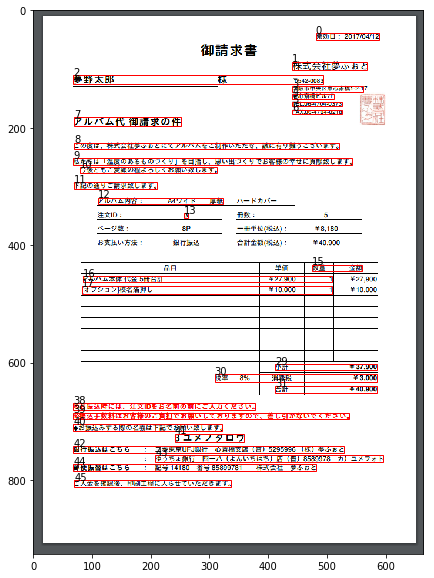

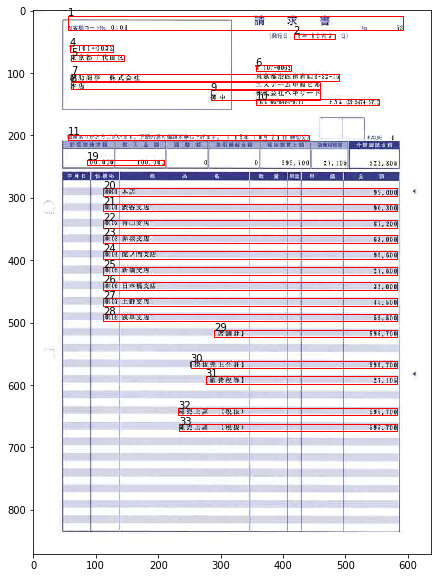

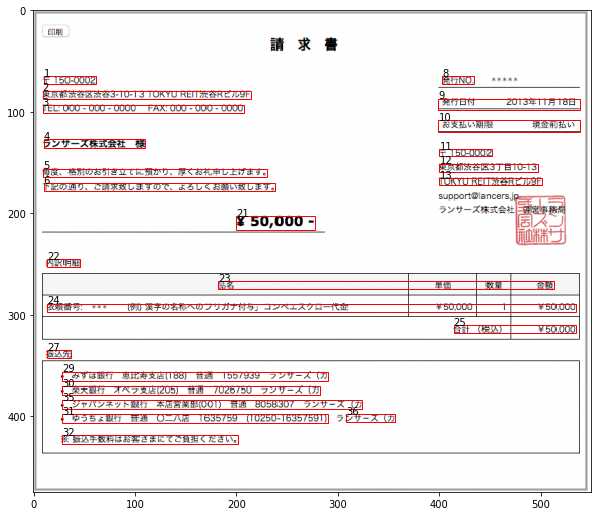

In [32]:
execOCRs(DATA_PATH + "input/")
# execOCR("13-07.png")

(25, 2)


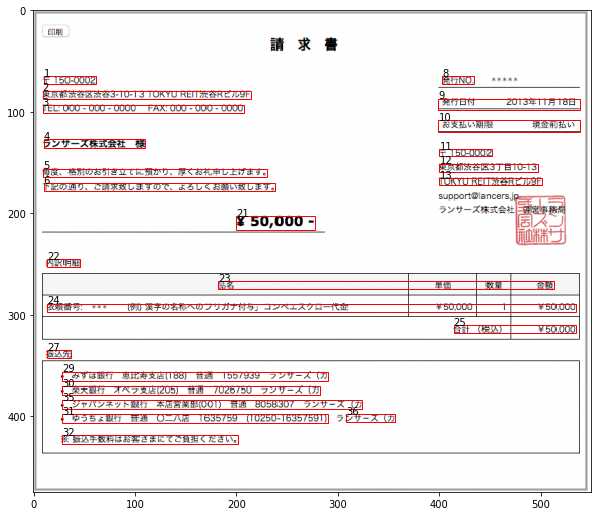

In [33]:
import matplotlib.patches as patches
img =  mpimg.imread("invoice.png")[:, :, :channels]
displayImage(img, words, "abcd")


# plt.imshow(img)

# ax = plt.axes()
# r = patches.Rectangle(xy=(100, 100), width=100, height=100, ec='#000000', fill=False)
# ax.add_patch(r)
# plt.plot( [50, 350], [200, 200], 'r', lw=5 )
# plt.imshow(img)

# fig = plt.figure(figsize=(10,10))
# # ax1 = fig.add_subplot(2,1,1)
# # ax2 = fig.add_subplot(2,1,2)
# ax.imshow(img)


# ImageMatching
## SimpleFeatureMatching

### Histgram

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

In [5]:
DATA_BASE = "./data/data-IM/"
DATA_INPUT = DATA_BASE + "input/"
DATA_OUTPUT = DATA_BASE + "output/"

In [6]:
imageA = cv2.imread(DATA_INPUT + "0001.jpg")
imageB = cv2.imread(DATA_INPUT + "0002.jpg")

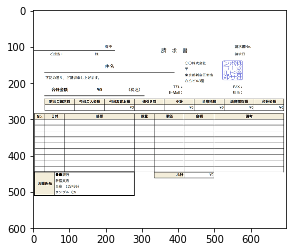

In [7]:
plt.imshow(imageA)

In [26]:
from operator import itemgetter
import csv

def calcHist(FILE_PATH, IMG_SIZE=(200,200)):
    img = cv2.imread(FILE_PATH)
    img = cv2.resize(img, IMG_SIZE)
    return cv2.calcHist([img],[0], None,[256],[0,256])

def compHists(IMG_DIR, TARGET_FILE,IMG_SIZE=(200,200), sort=True):
    # Target
    target_hist = calcHist(IMG_DIR + TARGET_FILE)
    print("TARGET:"+ TARGET_FILE)
    
    # Comp
    out = []
    files = os.listdir(IMG_DIR)
    for file in files:
        if file == '.DS_Store' or file == TARGET_FILE:
            continue
        comparing_img_path = IMG_DIR + file
        comparing_img = cv2.imread(comparing_img_path)
        comparing_img = cv2.resize(comparing_img, IMG_SIZE)
        comparing_hist = cv2.calcHist([comparing_img], [0], None, [256], [0, 256])
        ret = cv2.compareHist(target_hist, comparing_hist, 1)
        out.append([TARGET_FILE, file, ret])
    if sort:
        out = sorted(out, key=itemgetter(1), reverse=True)
    return out

def compHistsAll(IMG_DIR, IMG_SIZE=(200,200), sort=True):
    # Comp
    out = []
    files = os.listdir(IMG_DIR)
    for file in files:
        if file == '.DS_Store':
            continue
        out.append(compHists(IMG_DIR,file,sort=False))
    return out

def saveComp(comp, OUTPUT_DIR, FILE_NAME, params=None):
    pd.Series(comp).to_csv(OUTPUT_DIR + "comp_" + FILE_NAME + ".csv")

In [43]:
class ImageSearch(object):
    ARG_INDEX = ['target', 'source', 'histCorr', 'histBhat', 'AKAZE', 'ORB']
    def __init__(self, INPUT_DIR, OUTPUT_DIR):
        self.INPUT_DIR = INPUT_DIR
        self.OUTPUT_DIR = OUTPUT_DIR
    def execComp(self, TARGET_FILE=None):
        # Target
        valT = self.calcVal(TARGET_FILE)
        # Comp
        df = pd.DataFrame(columns=ImageSearch.ARG_INDEX)
        files = os.listdir(self.INPUT_DIR)
        for file in files:
            if file == '.DS_Store' or file == TARGET_FILE:
                continue
            valS = self.calcVal(file)
            cVal = self.compVal(valT,valS)
            df = df.append(cVal, ignore_index=True)
        # save
        df.to_csv(self.OUTPUT_DIR + "comp_" + TARGET_FILE + "_" + Util.getNow() + ".csv")
        return df
    
    def calcVal(self, TARGET_FILE):
        val = {}
        img = cv2.imread(self.INPUT_DIR + TARGET_FILE)
        # info
        val['name'] = TARGET_FILE
        # calc(Histgram)
        val['hist'] = self.calcHist(img)
        # calc(AKAZE,ORB)
        val['AKAZE'] = self.calcAKAZE(img)
        val['ORB'] = self.calcORB(img)
        return val
    
    def compVal(self, valT,valS):
        data = []
        data.append(valT['name'])
        data.append(valS['name'])
        # comp(Histgram-Corr,Bhattacharyya)
        data.append(cv2.compareHist(valT['hist'], valS['hist'], 0))
        data.append(cv2.compareHist(valT['hist'], valS['hist'], 3))
        # comp(BFM-AKAZE,ORB)
        data.append(self.compBFM(valT['AKAZE'], valS['AKAZE']))
        data.append(self.compBFM(valT['ORB'], valS['ORB']))
        # out
        return pd.Series(data=data, index=ImageSearch.ARG_INDEX)

    ##-----------------------
    ## CalcFeature
    ##-----------------------
    def calcHist(self, img, IMG_SIZE=(200,200)):
        if IMG_SIZE != None:
            img = cv2.resize(img, IMG_SIZE)
        hist = cv2.calcHist([img],[0], None, [256], [0, 256])
        return hist

    def calcAKAZE(self, img, IMG_SIZE=(200,200)):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        detector = cv2.AKAZE_create()
        (kp, des) = detector.detectAndCompute(img, None)
        return des

    def calcORB(self, img, IMG_SIZE=(200,200)):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        detector = cv2.ORB_create()
        (kp, des) = detector.detectAndCompute(img, None)
        return des
    
    ##-----------------------
    ## CompFeature
    ##-----------------------
    def compBFM(self, desT, desS):
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.match(desT, desS)
        dist = [m.distance for m in matches]
        ret = sum(dist) / len(dist)
        return ret


In [44]:
from datetime import datetime
import json
class Util(object):
    @classmethod
    def getNow(cls):
        return datetime.now().strftime("%Y%m%d%H%M%S")
    @classmethod
    def loadData(self, dataPath):
        with open(dataPath) as f:
            df = json.load(f)
        return df

In [45]:
ims = ImageSearch(DATA_INPUT, DATA_OUTPUT)
out = ims.execComp("0001.jpg")

In [30]:
out

,target,source,histCorr,histBhat,AKAZE,ORB
0,0001.jpg,0002.jpg,0.999141,0.238914,86.895660,46.618
1,0001.jpg,0003.jpg,0.998132,0.295601,138.151431,63.956
2,0001.jpg,0004.jpg,0.999428,0.201427,105.585411,48.220
3,0001.jpg,0005.jpg,0.992530,0.350003,107.812558,61.264
4,0001.jpg,0006.jpg,0.998634,0.274147,109.912281,56.776
5,0001.jpg,0007.jpg,0.796756,0.509232,158.229917,65.238
6,0001.jpg,0008.jpg,0.999246,0.194180,109.871653,52.588
7,0001.jpg,0009.jpg,0.981249,0.346061,120.167128,56.956
8,0001.jpg,0010.jpg,0.996074,0.281433,111.296399,58.002


In [96]:
out = compHistsAll(DATA_INPUT)
# TARGET_FILE = "0002.jpg"
# out = compHists(DATA_INPUT, TARGET_FILE)
# saveComp(out, DATA_OUTPUT, TARGET_FILE)

TARGET:0001.jpg
TARGET:0002.jpg
TARGET:0003.jpg
TARGET:0004.jpg
TARGET:0005.jpg
TARGET:0006.jpg
TARGET:0007.jpg
TARGET:0008.jpg
TARGET:0009.jpg
TARGET:0010.jpg


In [105]:
type(out)

list

In [18]:
IMG_SIZE = (200,200)
imageA = cv2.imread(DATA_INPUT + "0001.jpg", cv2.IMREAD_GRAYSCALE)
imageA = cv2.resize(imageA, IMG_SIZE)

imageB = cv2.imread(DATA_INPUT + "0002.jpg", cv2.IMREAD_GRAYSCALE)
imageB = cv2.resize(imageB, IMG_SIZE)

In [22]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
detector = cv2.AKAZE_create()
(target_kp, target_des) = detector.detectAndCompute(imageA, None)
(comp_kp, comp_des) = detector.detectAndCompute(imageB, None)
matches = bf.match(target_des, comp_des)
dist = [m.distance for m in matches]
ret = sum(dist) / len(dist)

In [23]:
ret

139.2948717948718